Download FER-2013 from Kaggle

In [1]:
pip install kaggle

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
# Specify the directory to save the dataset
save_directory_data = os.path.expanduser('~/Downloads')
os.makedirs(save_directory_data, exist_ok=True)
# Download the dataset
os.system(f'kaggle datasets download -d msambare/fer2013 -p "{save_directory_data}"')

Dataset URL: https://www.kaggle.com/datasets/msambare/fer2013
License(s): DbCL-1.0
fer2013.zip: Skipping, found more recently modified local copy (use --force to force download)


0

In [3]:
import cv2
import matplotlib.pyplot as plt
import random
from collections import Counter
import numpy as np
import pandas as pd
import random
from torchvision import transforms
from PIL import Image
from sklearn.model_selection import train_test_split
import shutil
from sklearn.preprocessing import LabelEncoder
from skimage import exposure
import os
import matplotlib.pyplot as plt
import mediapipe as mp
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from sklearn.model_selection import KFold, cross_val_score
from sklearn.svm import SVC

In [4]:
# Directory paths
train_dir = os.path.expanduser('/Users/sherrywang/Desktop/fer2013/train')
test_dir = os.path.expanduser('/Users/sherrywang/Desktop/fer2013/test')

In [5]:
# Define a function to load data
def load_images_from_directory(directory):
    images = []
    labels = []
    for label in os.listdir(directory):
        label_path = os.path.join(directory, label)
        if os.path.isdir(label_path):
            for file in os.listdir(label_path):
                file_path = os.path.join(label_path, file)
                image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
                images.append(image)
                labels.append(label)
    return images, labels

# Load training and testing images
train_images, train_labels = load_images_from_directory(train_dir)
test_images, test_labels = load_images_from_directory(test_dir)

print(f"Loaded {len(train_images)} training images and {len(test_images)} testing images.")

Loaded 28709 training images and 7178 testing images.


In [6]:
# Define a function to count the number of images in each category
def count_images_per_category(labels, dataset_label):
    category_counts = Counter(labels)
    total_images = len(labels)
    
    # Print the counts for each category
    print(f"\n{dataset_label} set:")
    for category, count in category_counts.items():
        print(f"Category '{category}': {count} images")
    
    print(f"Total number of images in {dataset_label} set: {total_images}")
    return category_counts, total_images

# Count images in training and testing
train_counts, num_train_images = count_images_per_category(train_labels, "Training")
test_counts, num_test_images = count_images_per_category(test_labels, "Testing")


Training set:
Category 'happy': 7215 images
Category 'sad': 4830 images
Category 'fear': 4097 images
Category 'surprise': 3171 images
Category 'neutral': 4965 images
Category 'angry': 3995 images
Category 'disgust': 436 images
Total number of images in Training set: 28709

Testing set:
Category 'happy': 1774 images
Category 'sad': 1247 images
Category 'fear': 1024 images
Category 'surprise': 831 images
Category 'neutral': 1233 images
Category 'angry': 958 images
Category 'disgust': 111 images
Total number of images in Testing set: 7178


Visualzie Random Samples from Each Category

Label: disgust


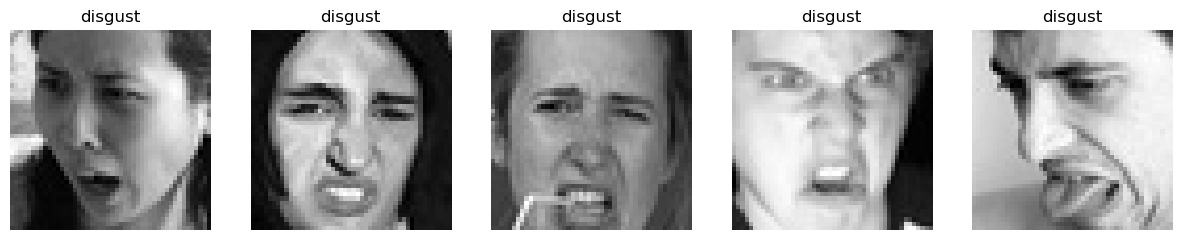

Label: fear


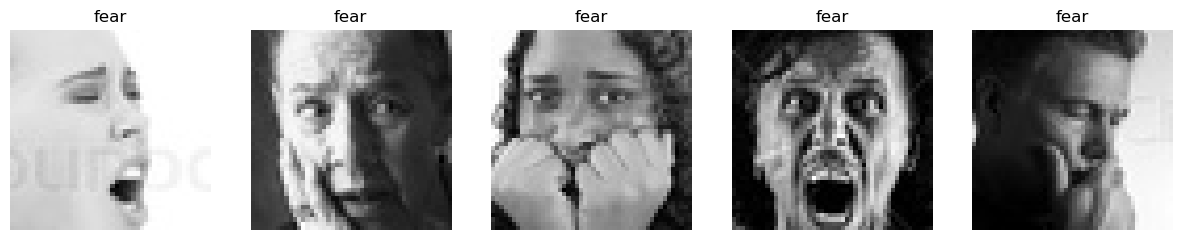

Label: surprise


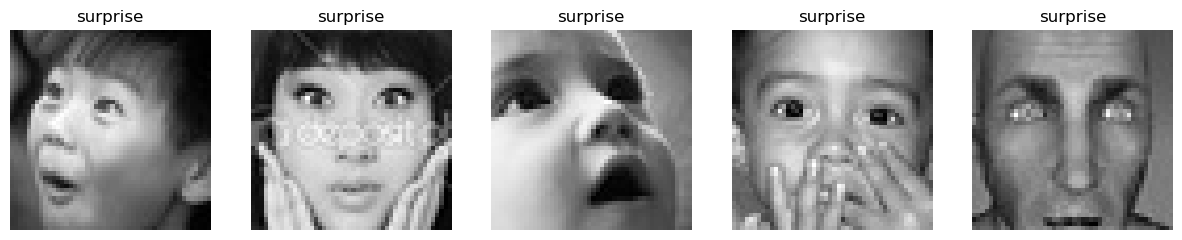

Label: neutral


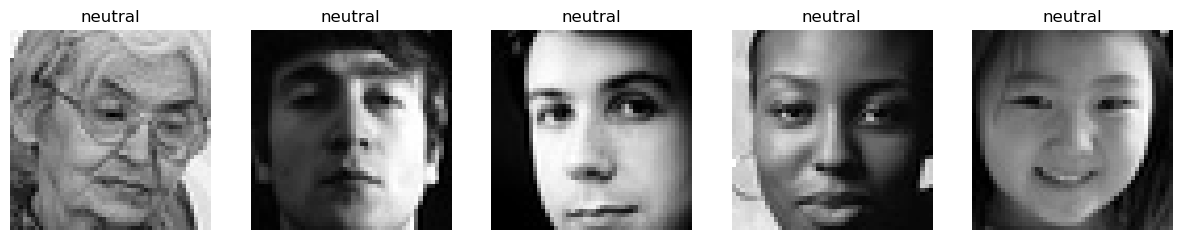

Label: happy


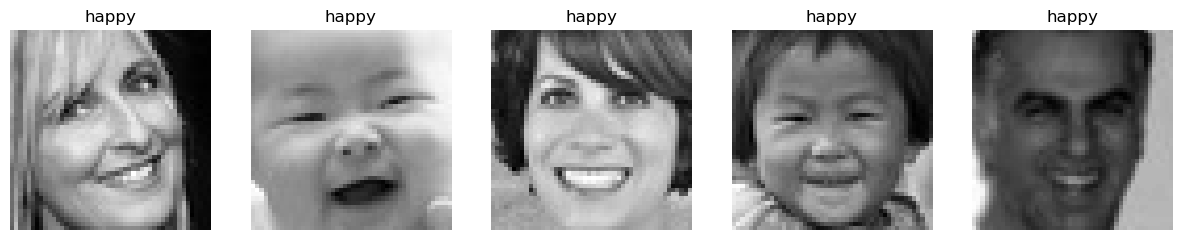

Label: angry


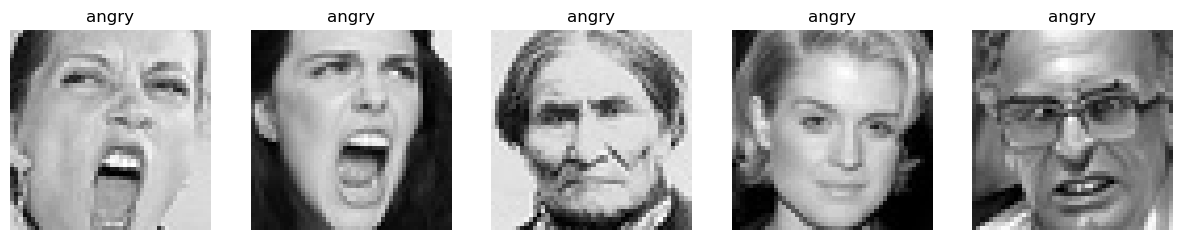

Label: sad


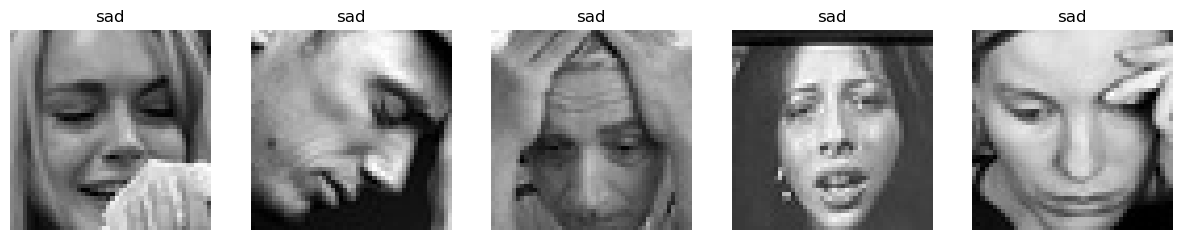

Label: disgust


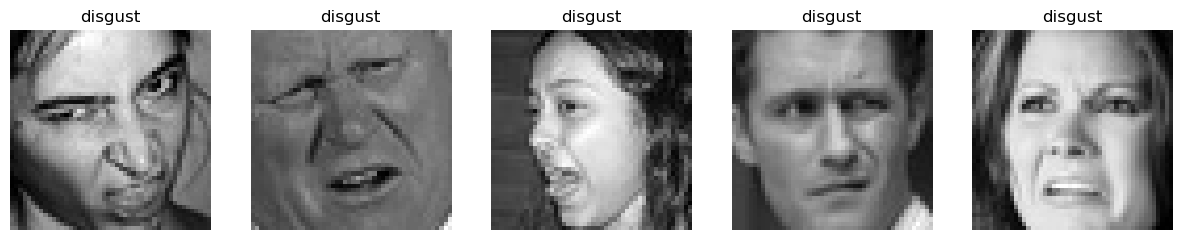

Label: fear


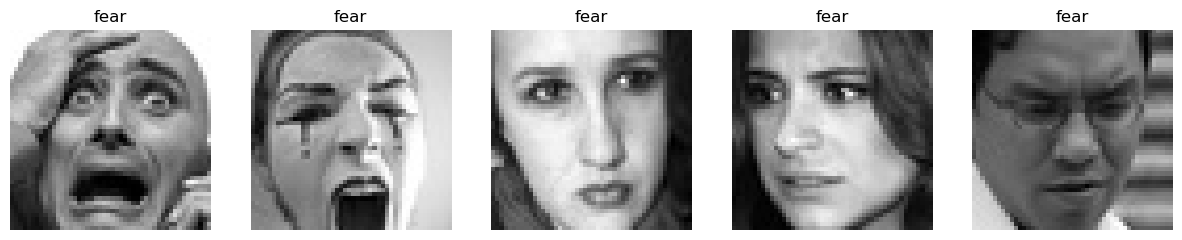

Label: surprise


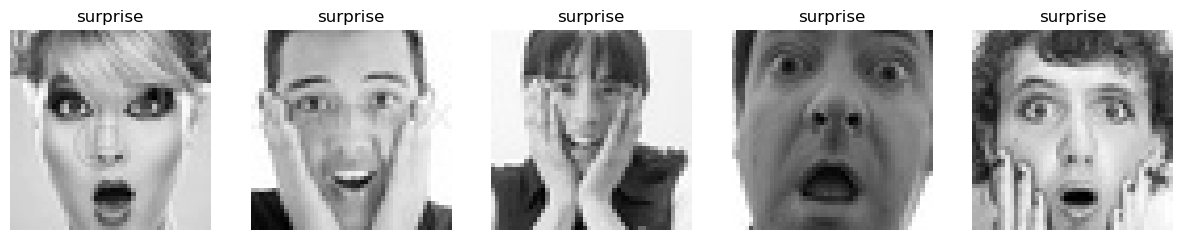

Label: neutral


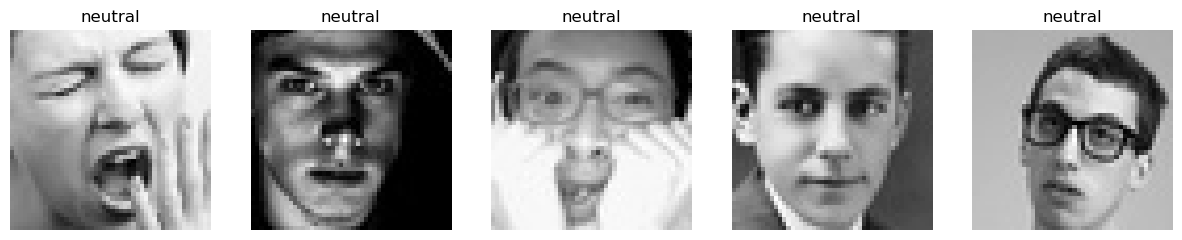

Label: happy


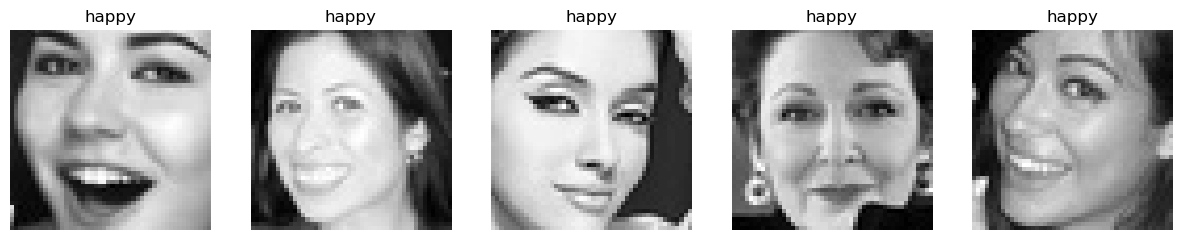

Label: angry


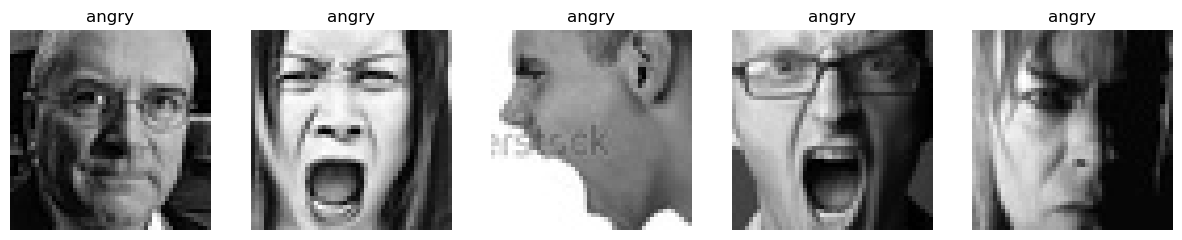

Label: sad


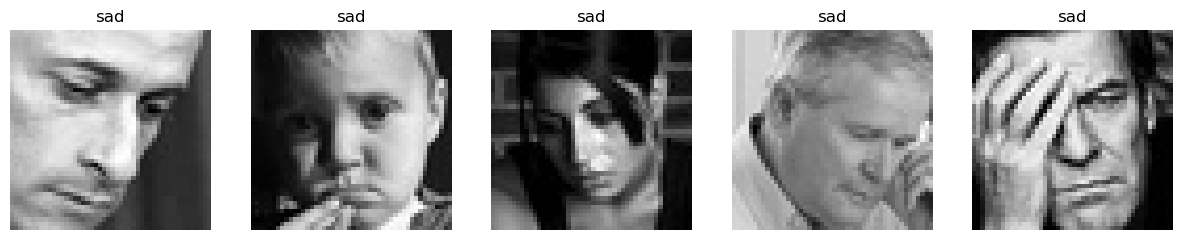

In [7]:
# Define a function to visualize random samples from each category
def visualize_samples(images, labels, num_samples=5, dataset_label="Dataset"):
    unique_labels = set(labels)
    
    for label in unique_labels:
        label_images = [img for img, lbl in zip(images, labels) if lbl == label]
        
        print(f"Label: {label}")
        sample_images = random.sample(label_images, min(num_samples, len(label_images)))
        
        plt.figure(figsize=(15, 3))
        for i, image in enumerate(sample_images):
            plt.subplot(1, num_samples, i + 1)
            plt.imshow(image, cmap='gray')
            plt.title(label)
            plt.axis('off')
        
        plt.show()

# Visualize samples from training and testing
visualize_samples(train_images, train_labels, num_samples=5, dataset_label="Training")
visualize_samples(test_images, test_labels, num_samples=5, dataset_label="Testing")

Data Cleaning

In [8]:
# Define a function to check if images are loaded correctly and correct size
def check_images(images, labels, dataset_label="Dataset"):
    invalid_images = []
    for i, image in enumerate(images):
        if image is None or image.shape != (48, 48):
            print(f"Invalid image detected in {dataset_label} set: Label - {labels[i]}, Index - {i}")
            invalid_images.append((labels[i], i))  # Store label and index of invalid images
    print(f"Total invalid images in {dataset_label} set: {len(invalid_images)}")

# Check the training and testing sets in memory
check_images(train_images, train_labels, dataset_label="Training")
check_images(test_images, test_labels, dataset_label="Testing")

Total invalid images in Training set: 0
Total invalid images in Testing set: 0


Addressing Data Imbalance: Step 1 Downsample 'happy' to 5000 Images

Addressing Data Imbalance: Step 2 Augmentation

Count the Number of Images in Each Category

In [30]:
# Load training balanced dataset
train_images, train_labels = load_images_from_directory(train_dir)
test_images, test_labels = load_images_from_directory(test_dir)
# Count images in training balanced dataset
train_counts, num_train_images = count_images_per_category(train_labels, "Training")


Training set:
Category 'happy': 7215 images
Category 'sad': 4830 images
Category 'fear': 4097 images
Category 'surprise': 3171 images
Category 'neutral': 4965 images
Category 'angry': 3995 images
Category 'disgust': 436 images
Total number of images in Training set: 28709


Feature Extraction for Training Balanced Dataset

In [35]:

mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True, max_num_faces=1, refine_landmarks=True)  


def extract_mediapipe_features(image, label_images):
 
    """
    Extract facial landmarks using MediaPipe Face Mesh. If no face is detected,
    continually retry with a randomly selected and augmented image from the same label.
    
    Parameters:
    - image: The initial input image to extract features from.
    - label_images: List of images under the same label to select from if retry is needed.
    
    Returns:
    - feature_vector: List of landmark (x, y, z) coordinates.
    """

    while True:
        # Ensure image is of type uint8 (0-255 range)
        image_uint8 = np.array(image, dtype=np.uint8)
        
        # Convert to RGB if grayscale
        if len(image_uint8.shape) == 2:  # Grayscale image
            image_rgb = cv2.cvtColor(image_uint8, cv2.COLOR_GRAY2RGB)
        else:
            image_rgb = image_uint8
        
        # Verify and re-cast to ensure MediaPipe compatibility
        image_rgb = np.array(image_rgb, dtype=np.uint8)
        #print("Image shape after conversion:", image_rgb.shape, "Data type:", image_rgb.dtype)
        
        # Process with MediaPipe Face Mesh
        results = face_mesh.process(image_rgb)
        
        if results.multi_face_landmarks:
            # Extract landmark coordinates for the detected face
            feature_vector = []
            for landmark in results.multi_face_landmarks[0].landmark:
                x, y, z = landmark.x, landmark.y, landmark.z
                #flattened 1d features
                feature_vector.extend([x, y, z]) 
                #feature_vector.append([x, y, z])
            return feature_vector  # Return feature vector if landmarks are detected
        
        # If no face is detected, print message and retry with augmented image
        print("No face detected in the image. Retrying with augmented image...")
        image = random.choice(label_images)  # Randomly choose a new image from the same label


# Process each category separately
train_features = []
test_features = []
for label in set(train_labels):  # Iterate over each unique label
    # Filter images and labels for the current label
    label_images = [img for img, lbl in zip(train_images, train_labels) if lbl == label]
    
    # Process each image in the current label category
    for i, image in enumerate(label_images):
        #print(f"Processing image {i+1}/{len(label_images)} for label '{label}'")
        feature_vector = extract_mediapipe_features(image, label_images)  # Pass both image and label_images
        if feature_vector is not None:
            train_features.append(feature_vector)

print("Feature extraction completed.")

for label in set(test_labels):  # Iterate over each unique label
    # Filter images and labels for the current label
    label_images = [img for img, lbl in zip(test_images, test_labels) if lbl == label]
    
    # Process each image in the current label category
    for i, image in enumerate(label_images):
        #print(f"Processing image {i+1}/{len(label_images)} for label '{label}'")
        feature_vector = extract_mediapipe_features(image, label_images)  # Pass both image and label_images
        if feature_vector is not None:
            test_features.append(feature_vector)

print("Feature extraction completed.")


# Encode labels
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels)

# Specify the directory to save extracted features and encoded labels
save_directory_features = os.path.expanduser('~/Downloads/fer2013/ExtractedFeatures_media')
os.makedirs(save_directory_features, exist_ok=True)

# Save MediaPipe features and encoded labels
np.save(f'{save_directory_features}/train_Media.npy', train_features)
np.save(f'{save_directory_features}/train_labels_encoded_Media.npy', train_labels_encoded)
print("Features and labels saved successfully.")



I0000 00:00:1731704108.093552 2226658 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 88.1), renderer: Apple M3
W0000 00:00:1731704108.101903 2340467 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731704108.111167 2340469 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


No face detected in the image. Retrying with augmented image...
No face detected in the image. Retrying with augmented image...
No face detected in the image. Retrying with augmented image...
No face detected in the image. Retrying with augmented image...
No face detected in the image. Retrying with augmented image...
No face detected in the image. Retrying with augmented image...
No face detected in the image. Retrying with augmented image...
No face detected in the image. Retrying with augmented image...
No face detected in the image. Retrying with augmented image...
No face detected in the image. Retrying with augmented image...
No face detected in the image. Retrying with augmented image...
No face detected in the image. Retrying with augmented image...
No face detected in the image. Retrying with augmented image...
No face detected in the image. Retrying with augmented image...
No face detected in the image. Retrying with augmented image...
No face detected in the image. Retrying 

In [13]:

    """# Load HOG features and encoded labels
train_features = np.load(f'{save_directory_features}/train_Media.npy')
train_labels_encoded = np.load(f'{save_directory_features}/train_labels_encoded_Media.npy')
print("Features and labels loaded successfully.")

# Print the shape of train_features
print("Shape of train MediaPipe features:", train_features.shape)
    """

'# Load HOG features and encoded labels\ntrain_features = np.load(f\'{save_directory_features}/train_Media.npy\')\ntrain_labels_encoded = np.load(f\'{save_directory_features}/train_labels_encoded_Media.npy\')\nprint("Features and labels loaded successfully.")\n\n# Print the shape of train_features\nprint("Shape of train MediaPipe features:", train_features.shape)\n'

In [28]:
# Load training balanced dataset
test_images, test_labels = load_images_from_directory(test_dir)

In [14]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, cross_val_predict, cross_val_score, KFold, StratifiedKFold, train_test_split
from sklearn.metrics import classification_report

In [54]:
# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(train_features)

# Apply PCA to reduce dimensionality
pca = PCA(n_components=15)
X_train_pca = pca.fit_transform(X_train_scaled)

# Check the amount of variance explained by the components
explained_variance = np.sum(pca.explained_variance_ratio_)
print(f"Explained variance with {pca.n_components_} components: {explained_variance:.2f}")

Explained variance with 15 components: 1.00


In [16]:
# Perform StratifiedKFold cross-validation on knn



# Create pipeline object
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=15)),
    ('knn', KNeighborsClassifier())
])

# Define the parameter grid for n_neighbors
param_grid = {
    'knn__n_neighbors': range(1, 201)  # Test n_neighbors from 1 to 200
}

# Stratified CV object
skcv = StratifiedKFold(n_splits=10, shuffle=True, random_state=2024)

# Initialize GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=skcv, scoring='accuracy')

# Fit the grid search
grid_search.fit(train_features, train_labels_encoded)

# Print the results
print("Best n_neighbors:", grid_search.best_params_['knn__n_neighbors'])
print("Best accuracy:", grid_search.best_score_)


Best n_neighbors: 1
Best accuracy: 0.38287618465078516


In [17]:
# Print the results for each n_neighbors
for i in range(1, 201):
    print(f"n_neighbors = {i}:")
    print(f"  Mean cross-validation score: {grid_search.cv_results_[f'mean_test_score'][i-1]:.4f}")
    # print(f"  Standard deviation: {grid_search.cv_results_[f'std_test_score'][i-1]:.4f}")

n_neighbors = 1:
  Mean cross-validation score: 0.3829
n_neighbors = 2:
  Mean cross-validation score: 0.3483
n_neighbors = 3:
  Mean cross-validation score: 0.3420
n_neighbors = 4:
  Mean cross-validation score: 0.3420
n_neighbors = 5:
  Mean cross-validation score: 0.3445
n_neighbors = 6:
  Mean cross-validation score: 0.3457
n_neighbors = 7:
  Mean cross-validation score: 0.3439
n_neighbors = 8:
  Mean cross-validation score: 0.3468
n_neighbors = 9:
  Mean cross-validation score: 0.3460
n_neighbors = 10:
  Mean cross-validation score: 0.3477
n_neighbors = 11:
  Mean cross-validation score: 0.3456
n_neighbors = 12:
  Mean cross-validation score: 0.3466
n_neighbors = 13:
  Mean cross-validation score: 0.3444
n_neighbors = 14:
  Mean cross-validation score: 0.3448
n_neighbors = 15:
  Mean cross-validation score: 0.3468
n_neighbors = 16:
  Mean cross-validation score: 0.3467
n_neighbors = 17:
  Mean cross-validation score: 0.3475
n_neighbors = 18:
  Mean cross-validation score: 0.3468
n

0

In [24]:
best_index = np.argmax(grid_search.cv_results_['mean_test_score'])

In [18]:
grid_search.cv_results_

{'mean_fit_time': array([2.90641227, 2.90109937, 3.07034688, 2.90586088, 2.89019134,
        2.88249488, 3.00415306, 2.87493548, 2.9887548 , 2.96001368,
        2.93081555, 2.91503329, 2.90239112, 2.88799169, 2.87533834,
        2.98011663, 2.86563711, 2.86959116, 2.88632913, 3.03140118,
        2.87043309, 2.8930006 , 2.9701019 , 2.99712887, 3.04279473,
        3.04525154, 2.85788305, 2.86206105, 2.90551755, 2.85935228,
        2.85724084, 2.85663552, 2.85855806, 2.89805667, 2.85166531,
        2.84944062, 2.86237922, 2.85703485, 2.84787941, 2.84213474,
        2.85034506, 2.84279952, 2.86417396, 2.88182979, 2.88224208,
        2.85509715, 2.85143173, 2.90626528, 2.84670081, 2.85632982,
        2.84372854, 2.84934525, 2.84356697, 2.84068387, 2.85130191,
        2.84986107, 2.8781867 , 2.84556024, 2.85577574, 2.87604907,
        2.84412591, 3.00463977, 3.01476259, 2.97151401, 2.97523935,
        2.9782639 , 2.98391378, 2.9801132 , 2.97620044, 2.9854655 ,
        2.97605691, 2.97545443,

In [25]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=15)),
    ('knn', KNeighborsClassifier(1))
])

predictions = cross_val_predict(pipeline, train_features, train_labels_encoded, cv=skcv)

# Print detailed classification report
print(classification_report(train_labels_encoded, predictions))


              precision    recall  f1-score   support

           0       0.34      0.34      0.34      3995
           1       0.04      0.04      0.04       436
           2       0.29      0.28      0.28      4097
           3       0.56      0.56      0.56      7215
           4       0.38      0.38      0.38      4965
           5       0.34      0.36      0.35      4830
           6       0.27      0.25      0.26      3171

    accuracy                           0.38     28709
   macro avg       0.32      0.32      0.32     28709
weighted avg       0.38      0.38      0.38     28709



In [37]:

test_labels_encoded = label_encoder.fit_transform(test_labels)

In [55]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=15)),
    ('knn', KNeighborsClassifier(1))
])

predictions = cross_val_predict(pipeline, test_features, test_labels_encoded, cv=skcv)

# Print detailed classification report
print(classification_report(test_labels_encoded, predictions))

              precision    recall  f1-score   support

           0       0.31      0.30      0.31       958
           1       0.02      0.02      0.02       111
           2       0.28      0.28      0.28      1024
           3       0.46      0.45      0.45      1774
           4       0.34      0.35      0.34      1233
           5       0.29      0.31      0.30      1247
           6       0.28      0.26      0.27       831

    accuracy                           0.34      7178
   macro avg       0.28      0.28      0.28      7178
weighted avg       0.34      0.34      0.34      7178

